# Let's analyze the BRO and BRO complex dataset

# Step 1: Load Data

In [205]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# create a pandas dataframe object
df1 = pd.read_csv('bro_aht_vol.csv', parse_dates=['date'],
                index_col=['date'], usecols=[0,1,2,3,4], header=1,
                names=['date', 'volume', 'volume_forecast', 'handle_time', 'handle_time_forecast'])

# header=1, 
# usecols=[1,3,4], parse_dates=['Date'],
# index_col=['Date'], names=['Date', 'forecast', 'actual']
display(df1.head())

df = df1.copy()

,volume,volume_forecast,handle_time,handle_time_forecast
date,,,,
2016-01-04,790,972,500887.0,NaN
2016-01-05,631,844,442528.0,NaN
2016-01-06,547,828,397061.0,NaN
2016-01-07,598,740,402881.0,NaN
2016-01-08,589,745,412462.0,NaN


# Step 2: Clean and Analyze Data

The boxplots below show several outliers near 0, and a long tail of values in the uppper ranges.

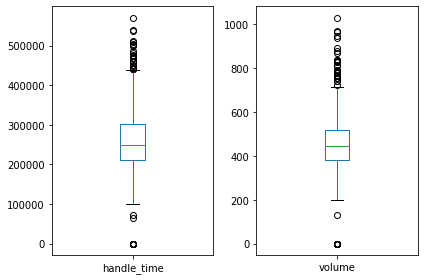

In [206]:
plt.subplot(121)
df['handle_time'].plot.box()

plt.subplot(122)
df['volume'].plot.box()
plt.tight_layout()
plt.show()

# What is the date range for the training data?
The available training data spans from January 4th, 2016 through August 13th, 2020

In [207]:
print('Start:', df.index.min())
print('End:', df.index.max())

Start: 2016-01-04 00:00:00
End: 2020-10-26 00:00:00


# Does the dataset contain weekends?
No it was prefiltered

In [208]:
df.index.weekday.isin([5,6]).any()

False

# Does the dataset contain holidays?
Yes, there are several holidays with data and a forecast; these will be omitted from the dataset for now.

In [209]:
h = pd.read_csv('holidays.csv')

df = df[~df.index.isin(h.iloc[:,0].tolist())]

In [210]:
# validate that no dates in the training data are weekends or holidays
df.index.weekday.isin([5,6]).any(),df.index.isin(h.iloc[:,0].tolist()).any()

(False, False)

## Is there any zero data or missed holidays?
Yes, a number of special holidays in 2016 were missed. These dates shall be omitted.

In [211]:
display(df[df['handle_time'] < 10000])

# filter dataframe
df = df[df['handle_time'] > 10000]

,volume,volume_forecast,handle_time,handle_time_forecast
date,,,,
2016-01-18,0,0,0.0,NaN
2016-02-15,0,0,0.0,NaN
2016-03-25,0,0,0.0,NaN
2016-05-30,0,0,0.0,NaN
2016-07-04,0,0,0.0,NaN
2016-09-05,0,0,0.0,NaN
2016-11-24,0,0,0.0,NaN
2016-12-26,0,0,0.0,NaN


# Is there any null data?

All null data is due to handle time forecast not being recorded prior to 2020.

In [212]:
df.isna().any()

volume                  False
volume_forecast         False
handle_time             False
handle_time_forecast     True
dtype: bool

# What date is the outlier value for handle time?
There was an unusually low handle time on April 23rd. That data point should be ommitted.

In [213]:
display(df[df['handle_time'] < 100000])

,volume,volume_forecast,handle_time,handle_time_forecast
date,,,,
2018-04-23,435,454,65745.0,NaN


In [214]:
display(df[df['handle_time'] < 100000])
 
df = df[df['handle_time'] > 100000]

,volume,volume_forecast,handle_time,handle_time_forecast
date,,,,
2018-04-23,435,454,65745.0,NaN


# How has the aht changed over time?

- The aht takes an interesting dip in mid-late 2018, and has been steadily increasing through 2020.

In [215]:
# create column for aht
df['aht'] = df['handle_time']/df['volume']

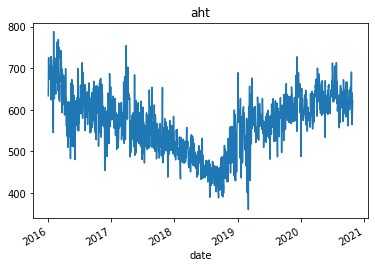

In [216]:
ax = df['aht'].plot()
plt.title('aht')
plt.show()

## The handle time and volume appear to follow the same seasonality, with matching peaks and troughs.

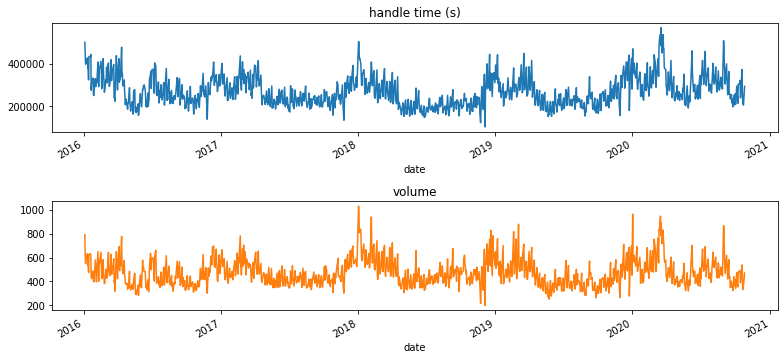

In [217]:
plt.figure(figsize=(11,7))
plt.subplot(311)
df['handle_time'].plot(color='#1f77b4')
plt.title('handle time (s)')
plt.subplot(312)
df['volume'].plot(color='#ff7f0e')
plt.title('volume')
plt.tight_layout()
plt.show()

# What is the relationship between volume and handle time?
There is a strong linear relationship between volume and handle time. As volume increases, total handle time increases, while higher volumes have more variable handle times. The scatter plot below confirms the intuition.

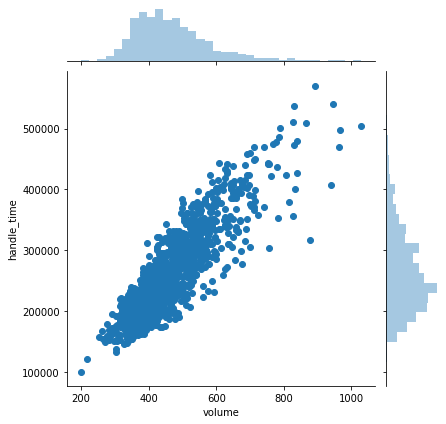

In [218]:
_ = sns.jointplot(x='volume', y='handle_time', data=df)

# What is the relationship between volume and aht?
There is a very weak linear relationship that is nearly flat.  As volume increases, aht decreases slightly.

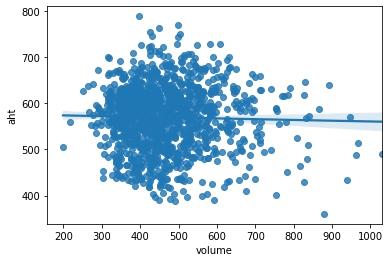

In [219]:
_ = sns.regplot(data=df,x='volume', y='aht' )

# What is the relationship between handle time and aht?
There is a strong linear relationship; As the total handle time increases, the aht tends to increase.

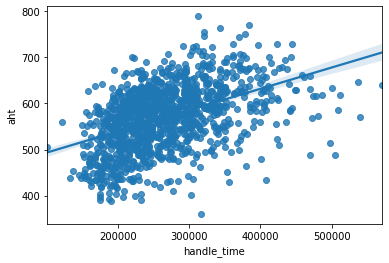

In [220]:
_ = sns.regplot(data=df,x='handle_time', y='aht' )

In [221]:
df['aht_forecast'] = df['handle_time_forecast']/df['volume_forecast']

# validate aht forecast is only null where handle_time_forecast is null 
(df[df['handle_time_forecast'].notnull()].index == df[df['aht_forecast'].notnull()].index).all()

True

# What date do the forecasts begin?


In [222]:
df[df['aht_forecast'].notnull()].head(1)

,volume,volume_forecast,handle_time,handle_time_forecast,aht,aht_forecast
date,,,,,,
2020-06-01,412,478,248207.0,275386.0,602.444175,576.121339


# What is the distribution of volume and aht?
- The median volume is 447 and is right skewed

- The median aht is around 577, and is slightly left-skewed.

In [223]:
df[['volume','aht']].describe()

,volume,aht
count,1213.000000,1213.000000
mean,465.820280,569.462456
std,109.268989,69.708025
min,199.000000,360.345103
25%,388.000000,523.764851
50%,447.000000,576.804622
75%,522.000000,618.479784
max,1030.000000,788.646465


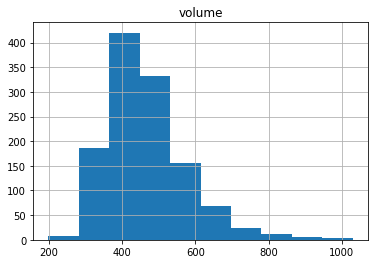

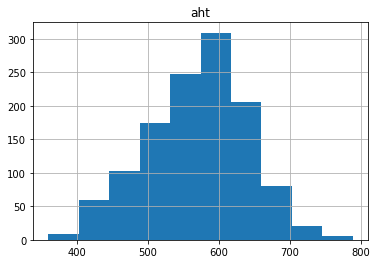

In [224]:
for col in ['volume', 'aht']:
    df[col].hist()
    plt.title(col)
    plt.show()

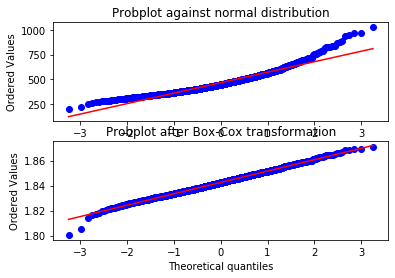

In [227]:
 
# fig = plt.figure()

# ax1 = fig.add_subplot(211)
# prob = stats.probplot(df['volume'], dist=stats.norm, plot=ax1)
# ax1.set_xlabel('')
# ax1.set_title('Probplot against normal distribution')



# ax2 = fig.add_subplot(212)

# xt, _ = stats.boxcox(df['volume'])

# prob = stats.probplot(xt, dist=stats.norm)

# rob = stats.probplot(xt, dist=stats.norm, plot=ax2)

# ax2.set_title('Probplot after Box-Cox transformation')

# plt.show()

# Step 3: Create Training Data and Fit Model for handle time
In order to train our model, we need to define a start and end date for the training data.
Typically, training should be performed with the most relevant or recent data.

In [538]:
# create a new dataframe with 2 columns, date and actual volume received
df['date'] = df.index
df = df[['date', 'handle_time']]

# Must pre-format column names
df.columns = ['ds','y']

# set start date of training data
df = df[df['ds'] >= '2017-01-01']

# set end date of training data
df = df[df['ds'] < '2020-06-01']
df.head()

,ds,y
date,,
2017-01-03,2017-01-03,400951.0
2017-01-04,2017-01-04,378328.0
2017-01-05,2017-01-05,303020.0
2017-01-06,2017-01-06,323159.0
2017-01-09,2017-01-09,350831.0


# Begin Training Model
Since this is the first model, only the default settings will be used. These settings, or hyperparameters can be tuned later, and will be a part of the model's feature engineering. Refer to the Prophet documentation at the [top of the page](#docs)

In [539]:
# create default prophet model
m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
m.fit(df)

# Create future dates
This function allows us to create the future dates that we want to predict. We will start with creating the next hundred days after August 13, 2020.

In [540]:
future = m.make_future_dataframe(periods=200)
future.tail()

,ds
1052,2020-12-11
1053,2020-12-12
1054,2020-12-13
1055,2020-12-14
1056,2020-12-15


# Make Predicitons on future dates

In [519]:
forecast = m.predict(future)

In [520]:
# view only the last 5 predictions with confidence intervals 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1052,2020-12-11,371428.467791,320732.228710,420154.868144
1053,2020-12-12,469330.717098,422136.485717,519019.575378
1054,2020-12-13,474252.087733,426583.413385,523660.986682
1055,2020-12-14,443232.101826,396416.355091,490965.095047
1056,2020-12-15,414475.957536,369996.640075,464546.658219


In [521]:
# query prediction for most recent date we have data for
forecast[forecast['ds'] == '2020-10-29'][['ds','yhat']]

,ds,yhat
1009,2020-10-29,283189.499637


# Visualize handle time seasonality and analyze trends.
The dark blue line is the prediction, the light blue line is the confidence interval, and the black dots is the actual volume. 

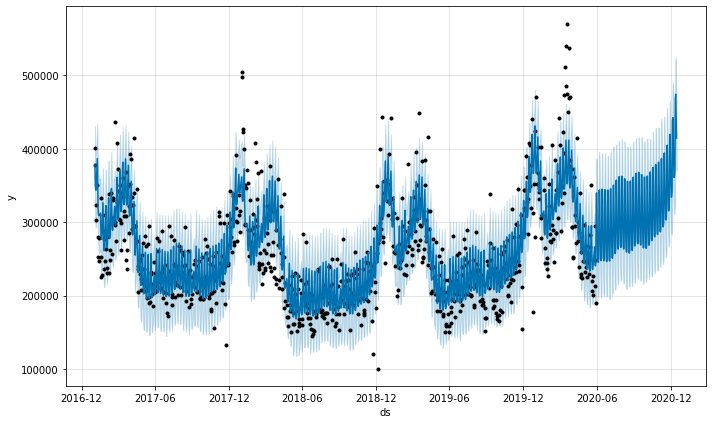

In [522]:
fig1 = m.plot(forecast)

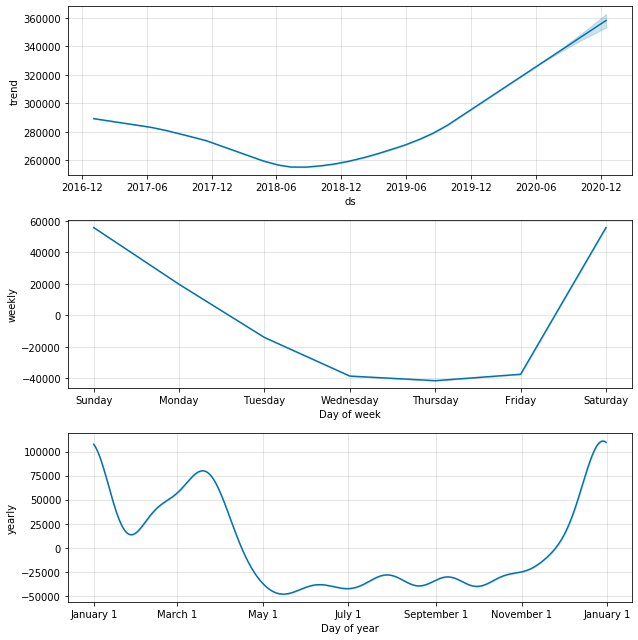

In [524]:
fig2 = m.plot_components(forecast)

In [479]:
# predict volume
df = df1.copy()

# create a new dataframe with 2 columns, date and actual volume received
df['date'] = df.index
df = df[['date', 'volume']]

# Must pre-format column names
df.columns = ['ds','y']

# set start date of training data
df = df[df['ds'] >= '2018-07-01']

# set end date of training data
df = df[df['ds'] < '2020-06-01']
df.head()

,ds,y
date,,
2018-07-02,2018-07-02,427
2018-07-03,2018-07-03,375
2018-07-04,2018-07-04,0
2018-07-05,2018-07-05,396
2018-07-06,2018-07-06,381


In [455]:
m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
m.fit(df)
future = m.make_future_dataframe(periods=200)
forecast = m.predict(future)


,ds,yhat
652,2020-10-29,443.693392


# These three plots help visualize the seasonality that our model is capturing. 

<b>Trend</b>: The trend, as we noted previously is trending down towards 2020, and trending up through the year to the current date.

<b>Weekly</b>: Monday is a peak that trends down throughout the weekdays to Thursday, and begins to trend upwards on Friday.  Ignore Saturday and Sunday, there are actually no calls being serviced on the weekends.

<b>Yearly</b>: As noted previously, there is a peak at the beginning and end of the year with local maximums in March and less so in July.



# Calculate model performance metrics for original model and prophet 
Compare these 2 different forecasts to the actual volume from dates 2020-8-17 through 2020-10-13.

Only calls received will be considered.

In [179]:
# Load current volume and forecast
df2 = pd.read_csv('https://raw.githubusercontent.com/majickdave/dji_vol/master/ris_forecast.csv', 
                  usecols=[0,1,2,3])
df2['date'] = pd.to_datetime(df2['date'])
df2.head()

,date,RECEIVED,FORECAST,HANDLED
0,2020-08-17,2404,2542,2274
1,2020-08-18,1922,2057,1764
2,2020-08-19,1926,1874,1779
3,2020-08-20,1769,1790,1724
4,2020-08-21,1933,1842,1643


In [180]:
# create forecast window
f = forecast[(forecast['ds']>='2020-08-17') & (
    forecast['ds']<'2020-10-14')][['ds','yhat', 'yhat_lower', 'yhat_upper']]

# get rid of weekends
f = f[~f['ds'].dt.weekday.isin([5,6])]

# drop the holiday labor day 2020
f = f[f['ds']!='2020-09-07']

In [181]:
def validate_dates(f, df2):
    """
    take in forecast, f
    and dataframe df2 and return Bool
    """
    res = []
    # validate forecast dates shape equals actual dates shape
    v1 = df2.shape[0] == f.shape[0]
    if not v1:
        return False
    else: res.append(v1)
        
    # validate all dates for forecast equal actual dates
    res.append(all(df2['date'].dt.date.values == f['ds'].dt.date.values))
    
    return all(res)

print(validate_dates(f, df2))

True


In [182]:
# join actual and current forecast to dataframe f
f['actual'] = df2['RECEIVED'].values

f['forecast'] = df2['FORECAST'].values

# Calculate Mean Absolute Percentage Error (MAPE)

In [183]:
def get_error(f, metric='MAPE'):
    """
    take in a dataframe f, of predictions, y_hat,
    and a list of actuals, y and return
    a float
    metric can be ['MAPE', 'RMSE']
    """
    res = {}
    # Do MAPE calc
    if metric == 'MAPE':
        res['prophet'] = ((f['actual']-f['yhat'])/f['actual']).abs().sum()/f.shape[0] * 100
        res['forecast'] = ((f['actual']-f['forecast'])/f['actual']).abs().sum()/f.shape[0] * 100
    # Do RMSE calc
    elif metric == 'RMSE':
        res['prophet'] = (((f['yhat']-f['actual'])**2).sum()/f.shape[0])**.5
        res['forecast'] = (((f['forecast']-f['actual'])**2).sum()/f.shape[0])**.5
    # TODO any other metric calc
    else:
        return 'There is an error with the metric'
    
    return pd.DataFrame(res, index=[metric])

mape, rmse = get_error(f), get_error(f, metric='RMSE')
display(mape)
# display(rmse)

# print(get_error(f, metric=1))

,prophet,forecast
MAPE,7.41866,8.212873


# Take a look at the 5 most recent predictions and compare to actual and forecasted volumes.

In [184]:
f['yhat'] = f['yhat'].round().astype(int)
f[['ds', 'yhat', 'actual', 'forecast']].tail()

,ds,yhat,actual,forecast
570,2020-10-07,2082,2014,2050
571,2020-10-08,1994,1971,1890
572,2020-10-09,2084,2240,1854
573,2020-10-12,2927,2678,2388
574,2020-10-13,2375,2617,2291


## The prophet model outperformed the current model on the MAPE metric by 0.8 percent.
MAPE is lower for the prophet model without any hyperparameter tuning, or feature engineering.

In [185]:
((mape['forecast'] - mape['prophet']).values[0]/100 * f['actual']).mean()

16.867727848135228

## Deploying this model for use in workforce planning could result in an average daily forecast accuracy improvement of 17 calls per day for RIS group. 

# Future Work

1. determine most important metric for forecasting in each business unit
    - tune hyperparameters of prophet model
    - work on analysis of forecasting
    - create different training, validation, and testing datasets (changing windows of time)

2. Create forecasts for handle time
    - repeat step 1

3. Create forecasts for other KPIs
    - repeat step 1
4. Test other time series models like ARIMA
5. Test Neural Networks (LSTM)


# Thank you